In [108]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

sess = tf.InteractiveSession()

# settings
LEARNING_RATE = 1e-4
TRAINING_ITERATIONS = 20000        
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 0

# image number to output
IMAGE_TO_DISPLAY = 52

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10e284990>> ignored


In [126]:
# read training data from CSV file 
data = pd.read_csv('../data/train.csv')

# 1 label + 4096 pixels = 4097
print('data({0[0]},{0[1]})'.format(data.shape))

# first 5 tensors
print (data.head())

data(2057,4097)
   label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5   pixel6  \
0      1      109      110      110      107      102       99      101   
1      1      108      107      105      105      108      109      107   
2      1      110      110      110      109      106      100       91   
3      1      105      107      109      106      103      108      110   
4      1      111      109      109      109      108      107      107   

    pixel7   pixel8     ...       pixel4086   pixel4087   pixel4088  \
0      104       86     ...             120         167         170   
1      105       96     ...             117         170         180   
2       85       88     ...             116         114         133   
3      107      108     ...             114         118         113   
4      109      106     ...              65          66          66   

    pixel4089   pixel4090   pixel4091   pixel4092   pixel4093   pixel4094  \
0         171         150    

In [127]:
images = data.iloc[:,1:].values

# convert to float for next step
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(2057,4096)


In [125]:
image_size = images.shape[1]
print 'image_size => '+ str(image_size)

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print 'image_width => '+ str(image_width)
print 'image_height => '+ str(image_height)

image_size => 4096
image_width => 64
image_height => 64


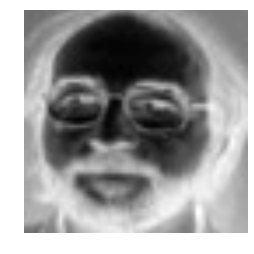

In [112]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# output image     
display(images[IMAGE_TO_DISPLAY])

In [113]:
labels_flat = data[[0]].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(2057)
labels_flat[52] => 1


In [114]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 2


In [115]:
# convert class labels from scalars to one-hot vectors
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(2057,2)
labels[52] => [0 1]


In [116]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(2057,4096)
validation_images(0,4096)


In [117]:
x = tf.placeholder(tf.float32, shape=[None, image_size])
y_ = tf.placeholder(tf.float32, shape=[None, labels_count])
W = tf.Variable(tf.zeros([4096,2]))
b = tf.Variable(tf.zeros([2]))

In [118]:
sess.run(tf.initialize_all_variables())
y = tf.nn.softmax(tf.matmul(x,W) + b)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)

In [119]:
# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
predict = tf.argmax(y,1)

epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [102]:
for i in range(1000):
  batch = next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

In [103]:

# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE]})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

training_accuracy => 0.8600 for step 0
training_accuracy => 0.7600 for step 1
training_accuracy => 0.7800 for step 2
training_accuracy => 0.8200 for step 3
training_accuracy => 0.8600 for step 4
training_accuracy => 0.7600 for step 5
training_accuracy => 0.8000 for step 6
training_accuracy => 0.8200 for step 7
training_accuracy => 0.7600 for step 8
training_accuracy => 0.7600 for step 9
training_accuracy => 0.8600 for step 10
training_accuracy => 0.8000 for step 20
training_accuracy => 0.8200 for step 30
training_accuracy => 0.7800 for step 40
training_accuracy => 0.6800 for step 50
training_accuracy => 0.8600 for step 60
training_accuracy => 0.8200 for step 70
training_accuracy => 0.8000 for step 80
training_accuracy => 0.8000 for step 90
training_accuracy => 0.7400 for step 100
training_accuracy => 0.7600 for step 200
training_accuracy => 0.8400 for step 300
training_accuracy => 0.8800 for step 400
training_accuracy => 0.8200 for step 500
training_accuracy => 0.8800 for step 600
trai

In [107]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

test_images(514,4096)
predicted_lables(514)
predicted_lables[52] => 1.0


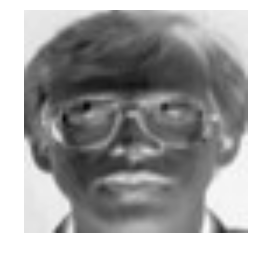

In [105]:
# read test data from CSV file 
test_images = pd.read_csv('../data/test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE]})


print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')